## New York City Taxi Dataset 2013

This notebook contains Data Modelling for predicting Trip Fares after Data Cleaning is done and both the trip data and fare data for October 2013 is merged into one dataset. For prediction I have used Linear Regression and XGBoost Regressor models.

In [1]:
# !pip3 install seaborn

### Importing the required libraries

In [2]:
import pandas as pd

import geopy
import geopy.distance as gd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns

import math
import numpy as np

from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xg

### Reading data from the cleaned and merged new york taxi data using pandas

In [3]:
taxi_trip_df = pd.read_csv('/data/shared/debdeep_guha/nyc_taxi_data/cleaned_full_taxi_data.csv')

In [4]:
taxi_trip_df.head()

medallion                      hack_license  \
0  740BD5BE61840BE4FE3905CC3EBE3E7E  E48B185060FB0FF49BE6DA43E69E624B   
1  EA05309C30F375695F44C96108ACB10F  1D10D8AC5B07D80861761365A05A9AE2   
2  EA05309C30F375695F44C96108ACB10F  1D10D8AC5B07D80861761365A05A9AE2   
3  B36D7AB5B422EA1A0588EFD1D8155EF3  669F420B42A0739A5D1058184AD227ED   
4  28172009F5513B25F4091C0929C4515D  ABE08BCFEBF3F5F7339CA2170EEC1DEE   

  vendor_id  rate_code      pickup_datetime     dropoff_datetime  \
0       CMT          1  2013-10-01 12:44:29  2013-10-01 12:53:26   
1       CMT          1  2013-10-02 19:44:55  2013-10-02 20:03:55   
2       CMT          1  2013-10-02 22:01:18  2013-10-02 22:09:18   
3       CMT          1  2013-10-03 12:14:35  2013-10-03 12:26:04   
4       CMT          1  2013-10-02 00:33:37  2013-10-02 01:06:16   

   passenger_count  trip_time_in_secs  trip_distance  pickup_longitude  ...  \
0                1                536            1.2        -73.974319  ...   
1                1               1139            5.1        -73.981239  ...   
2                1                480            2.2        -74.002991  ...   
3                1                689            0.9        -73.967178  ...   
4                1               1959           14.8        -73.784142  ...   

   trip_dist_miles  trip_diff_seconds  avg_speed  payment_type  fare_amount  \
0         0.884191              537.0   8.044693           CRD          8.0   
1         2.075469             1140.0  16.105263           CRD         18.0   
2         0.454633              480.0  16.500000           CRD          9.5   
3         0.889170              689.0   4.702467           CRD          8.5   
4        10.234611             1959.0  27.197550           CRD         43.0   

   surcharge mta_tax  tip_amount  tolls_amount  total_amount  
0        0.0     0.5         2.1           0.0          10.6  
1        1.0     0.5         3.0           0.0          22.5  
2        0.5     0.5         2.1           0.0          12.6  
3        0.0     0.5         1.8           0.0          10.8  
4        0.5     0.5        11.0           0.0          55.0  

[5 rows x 23 columns]

In [5]:
# checking the column names in the dataset
taxi_trip_df.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_dist_miles', 'trip_diff_seconds', 'avg_speed', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount'],
      dtype='object')

In [6]:
# checking the length of the dataset
len(taxi_trip_df)

13895209

In [7]:
# the datatypes of all the columns in the dataset
taxi_trip_df.dtypes

medallion             object
hack_license          object
vendor_id             object
rate_code              int64
pickup_datetime       object
dropoff_datetime      object
passenger_count        int64
trip_time_in_secs      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_dist_miles      float64
trip_diff_seconds    float64
avg_speed            float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
dtype: object

#### Converting `dropoff_datetime` and `pickup_datetime` into datetime from type object

In [8]:
taxi_trip_df['dropoff_datetime'] =  pd.to_datetime(taxi_trip_df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_trip_df['pickup_datetime'] =  pd.to_datetime(taxi_trip_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

#### Extracting the day, hour and weekday number

In [9]:
taxi_trip_df['pickup_weekday'] = taxi_trip_df['pickup_datetime'].dt.dayofweek
taxi_trip_df['pickup_hour'] = taxi_trip_df['pickup_datetime'].dt.hour
taxi_trip_df['pickup_day'] = taxi_trip_df['pickup_datetime'].dt.day

#### Fare Amount Distribution

/home/ml/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Fare Amount Distribution')

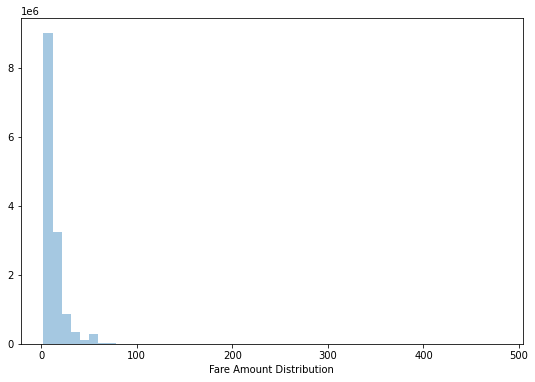

In [11]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.distplot(taxi_trip_df['fare_amount'], kde=False)
ax.set_xlabel('Fare Amount Distribution')

In [10]:
# checking the maximum fare amount
taxi_trip_df['fare_amount'].max()

480.0

In [12]:
# checking other values for the maximum fare amount
taxi_trip_df[taxi_trip_df['fare_amount'] == taxi_trip_df['fare_amount'].max()]

medallion                      hack_license  \
12931885  C85F202D4400ACD406CB4DE6850A0EDB  32379D76A4C3FB946DADD3F2866E8C6B   

         vendor_id  rate_code     pickup_datetime    dropoff_datetime  \
12931885       CMT          5 2013-10-04 00:50:20 2013-10-04 00:51:08   

          passenger_count  trip_time_in_secs  trip_distance  pickup_longitude  \
12931885                1                 47            0.1        -74.015343   

          ...  payment_type  fare_amount  surcharge  mta_tax  tip_amount  \
12931885  ...           CRD        480.0        0.0      0.0         0.0   

          tolls_amount total_amount  pickup_weekday  pickup_hour  pickup_day  
12931885           0.0        480.0               4            0           4  

[1 rows x 26 columns]

In [13]:
taxi_trip_df[taxi_trip_df['fare_amount'] == taxi_trip_df['fare_amount'].max()]['trip_diff_seconds']

12931885    48.0
Name: trip_diff_seconds, dtype: float64

In [14]:
# checking the top 50 highest fare amount values
taxi_trip_df.sort_values(by=['fare_amount'], ascending=False)['total_amount'].head(50)

12931885    480.00
13122835    450.01
2549028     450.01
9072835     450.00
6547134     479.50
11683802    450.50
9777392     424.11
295038      385.00
8701168     380.50
13654879    375.00
10518088    370.00
336286      360.00
3484026     350.00
4048436     350.00
6050315     325.00
533386      326.33
8890412     300.00
3671056     300.00
1969898     315.00
10486355    300.50
4616019     300.64
2557831     280.00
5526420     336.00
12774741    350.00
5393949     336.00
3053796     275.00
5432854     270.00
3734727     259.25
12389903    255.33
5196860     258.71
365482      240.00
5010480     250.75
1522900     284.40
8129431     241.83
785089      233.00
7754389     280.00
6177601     225.00
1929962     238.25
6188218     238.30
1234514     264.00
4417664     225.33
8467868     242.00
2820307     245.32
13057037    215.50
4249421     224.33
11786347    228.50
9032641     210.25
2674588     230.66
2051583     200.00
5751836     200.50
Name: total_amount, dtype: float64

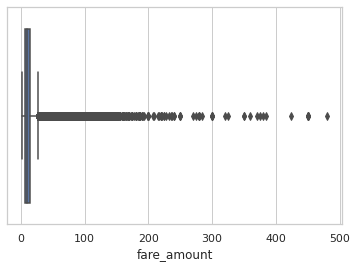

In [16]:
# the boxplot below shows a lot of outliers
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=taxi_trip_df["fare_amount"])

In [19]:
# checking the number of records that will be removed if stdev of 4 is selected
taxi_trip_df[(np.abs(stats.zscore(taxi_trip_df['fare_amount'])) > 4)]

medallion                      hack_license  \
189       FB44AC801A5E0C646781C90C3F9DFB56  11A6677A48CF6D3C17FA3F18AD4A68AC   
221       F605E00E7F30EA8A192451B8C3558DF2  5FC6FB04951DC550B958E6CDC1F0B992   
940       3519845B181E2C0C603FF23A320A1718  DF46CE34589E2AA3251F4F55DC80C71A   
975       5DB04ACE041C02E42BC57A25FF037AFA  6972A2B75B1963488B944F9B956D50A1   
1051      1573B667872D77E8130DB3A06A6975A7  30D8804C7CC2FD096389A05C3D29CB26   
...                                    ...                               ...   
13894688  AA61AF12089DFE53ED13E67F0A42120A  2C584442C9DC6740767CDE5672C12379   
13894718  DBA15F7F35F853A32486CE789D7C0499  3871B106F70A201F76E2E82A5C0735DF   
13894795  F09F782FAC8A0139ED3ACCB1AABA0689  A16383213C8C356120F2436E26963C40   
13895111  FE03F0961C73A4589ED4C40DFC60E771  90460D3132B627B0D04B17CA8DE772B9   
13895171  DB76A59BA9A4D49EEBBBDB90B8395FDB  9D6002CD59DCABF94DA8C66AAE5AA4F4   

         vendor_id  rate_code     pickup_datetime    dropoff_datetime  \
189            CMT          3 2013-10-10 16:37:07 2013-10-10 17:17:49   
221            CMT          1 2013-10-12 15:21:38 2013-10-12 16:19:59   
940            CMT          3 2013-10-09 11:42:40 2013-10-09 12:38:49   
975            CMT          1 2013-10-08 16:13:29 2013-10-08 17:37:53   
1051           CMT          1 2013-10-13 13:56:35 2013-10-13 14:43:20   
...            ...        ...                 ...                 ...   
13894688       CMT          1 2013-10-09 23:37:03 2013-10-10 00:11:15   
13894718       CMT          5 2013-10-10 23:08:38 2013-10-10 23:18:57   
13894795       CMT          5 2013-10-07 22:57:38 2013-10-07 23:14:29   
13895111       CMT          1 2013-10-09 21:08:17 2013-10-09 21:43:21   
13895171       CMT          3 2013-10-13 16:18:54 2013-10-13 16:56:44   

          passenger_count  trip_time_in_secs  trip_distance  pickup_longitude  \
189                     1               2442           17.0        -73.980911   
221                     1               3500           25.4        -74.008965   
940                     1               3369           18.9        -73.965759   
975                     2               5064           10.7        -73.985573   
1051                    1               2805           19.3        -73.788979   
...                   ...                ...            ...               ...   
13894688                1               2051           19.2        -73.982285   
13894718                1                618            3.3        -73.997696   
13894795                1               1010            6.1        -73.984978   
13895111                1               2104           23.0        -73.776848   
13895171                2               2270           15.1        -73.996971   

          ...  payment_type  fare_amount  surcharge  mta_tax  tip_amount  \
189       ...           CRD         67.5        1.0      0.0       15.20   
221       ...           CRD         72.5        0.0      0.5       14.60   
940       ...           CRD         80.0        0.0      0.0       15.00   
975       ...           CRD         58.5        1.0      0.5       12.00   
1051      ...           CRD         54.0        0.0      0.5       13.62   
...       ...           ...          ...        ...      ...         ...   
13894688  ...           CRD         53.5        0.5      0.5       15.50   
13894718  ...           CRD         60.0        0.0      0.0        0.00   
13894795  ...           CRD         55.0        0.0      0.0        0.00   
13895111  ...           CRD         61.0        0.5      0.5       10.00   
13895171  ...           CRD         63.5        0.0      0.0        8.00   

          tolls_amount total_amount  pickup_weekday  pickup_hour  pickup_day  
189              16.30       100.00               3           16          10  
221               0.00        87.60               5           15          12  
940              12.85       107.85               2           11        

In [54]:
# basically removing records with fare_amount more than 52.5$
taxi_trip_df[(np.abs(stats.zscore(taxi_trip_df['fare_amount'])) > 4)]['fare_amount'].min()

52.5

In [20]:
# keeping records which lie within the 4th standard deviation using z-score
upd_taxi_trip_df = taxi_trip_df[(np.abs(stats.zscore(taxi_trip_df['fare_amount'])) < 4)]

In [21]:
upd_taxi_trip_df.reset_index(drop=True, inplace=True)

In [22]:
upd_taxi_trip_df

medallion                      hack_license  \
0         740BD5BE61840BE4FE3905CC3EBE3E7E  E48B185060FB0FF49BE6DA43E69E624B   
1         EA05309C30F375695F44C96108ACB10F  1D10D8AC5B07D80861761365A05A9AE2   
2         EA05309C30F375695F44C96108ACB10F  1D10D8AC5B07D80861761365A05A9AE2   
3         B36D7AB5B422EA1A0588EFD1D8155EF3  669F420B42A0739A5D1058184AD227ED   
4         28172009F5513B25F4091C0929C4515D  ABE08BCFEBF3F5F7339CA2170EEC1DEE   
...                                    ...                               ...   
13836677  3FD555B8EA958A8AC0A50FCBEDED5CE2  A59A74F32FDFB59430AAC596A2B54FA6   
13836678  F72C82AFFA243C164EA00B43398EDFCD  1B8B820092E36B6BDEF66B2B836A5E1F   
13836679  400E7547B850AB2C980B02293A279988  265712C4B013561E39DA4EF5700BC8F0   
13836680  C612423A09BF7298B817EBB674E7DC11  F3E5CC66E8544AF5FF67DFB70B6A7481   
13836681  F8AE75FDCD0BF45E1BF0A5EFBDA347C9  312C04DAB9C496F8BBFDCBF4D382993D   

         vendor_id  rate_code     pickup_datetime    dropoff_datetime  \
0              CMT          1 2013-10-01 12:44:29 2013-10-01 12:53:26   
1              CMT          1 2013-10-02 19:44:55 2013-10-02 20:03:55   
2              CMT          1 2013-10-02 22:01:18 2013-10-02 22:09:18   
3              CMT          1 2013-10-03 12:14:35 2013-10-03 12:26:04   
4              CMT          1 2013-10-02 00:33:37 2013-10-02 01:06:16   
...            ...        ...                 ...                 ...   
13836677       CMT          1 2013-10-07 20:24:34 2013-10-07 20:30:22   
13836678       CMT          1 2013-10-08 17:34:04 2013-10-08 17:42:27   
13836679       CMT          1 2013-10-09 21:56:46 2013-10-09 22:03:43   
13836680       CMT          1 2013-10-10 02:11:50 2013-10-10 02:17:49   
13836681       CMT          1 2013-10-11 17:11:43 2013-10-11 17:34:30   

          passenger_count  trip_time_in_secs  trip_distance  pickup_longitude  \
0                       1                536            1.2        -73.974319   
1                       1               1139            5.1        -73.981239   
2                       1                480            2.2        -74.002991   
3                       1                689            0.9        -73.967178   
4                       1               1959           14.8        -73.784142   
...                   ...                ...            ...               ...   
13836677                1                347            1.0        -73.968300   
13836678                3                502            1.1        -73.985168   
13836679                1                416            1.8        -73.998978   
13836680                1                359            1.1        -73.985756   
13836681                1               1367            2.6        -73.999939   

          ...  payment_type  fare_amount  surcharge  mta_tax  tip_amount  \
0         ...           CRD          8.0        0.0      0.5        2.10   
1         ...           CRD         18.0        1.0      0.5        3.00   
2         ...           CRD          9.5        0.5      0.5        2.10   
3         ...           CRD          8.5        0.0      0.5        1.80   
4         ...           CRD         43.0        0.5      0.5       11.00   
...       ...           ...          ...        ...      ...         ...   
13836677  ...           CRD          6.0        0.5      0.5        1.00   
13836678  ...           CRD          7.0        1.0      0.5        2.10   
13836679  ...           CRD          8.0        0.5      0.5        1.80   
13836680  ...           CRD          6.5        0.5      0.5        1.50   
13836681  ...           CRD         15.0        1.0      0.5        4.12   

          tolls_amount total_amount  pickup_weekday  pickup_hour  pickup_day  
0                  0.0        10.60               1           12           1  
1                  0.0        22.50               2           19           2  
2                  0.0        12.60               2           22        

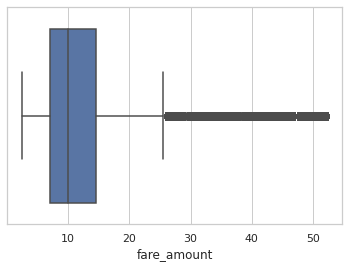

In [23]:
# a much better box plot
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=upd_taxi_trip_df["fare_amount"])

/home/ml/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Fare Amount Distribution')

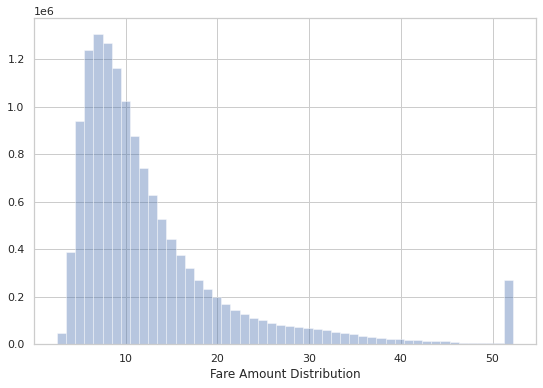

In [24]:
# checking the distribution after removing those records
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.distplot(upd_taxi_trip_df['fare_amount'], kde=False)
ax.set_xlabel('Fare Amount Distribution')

### Feature Importance using Correlation

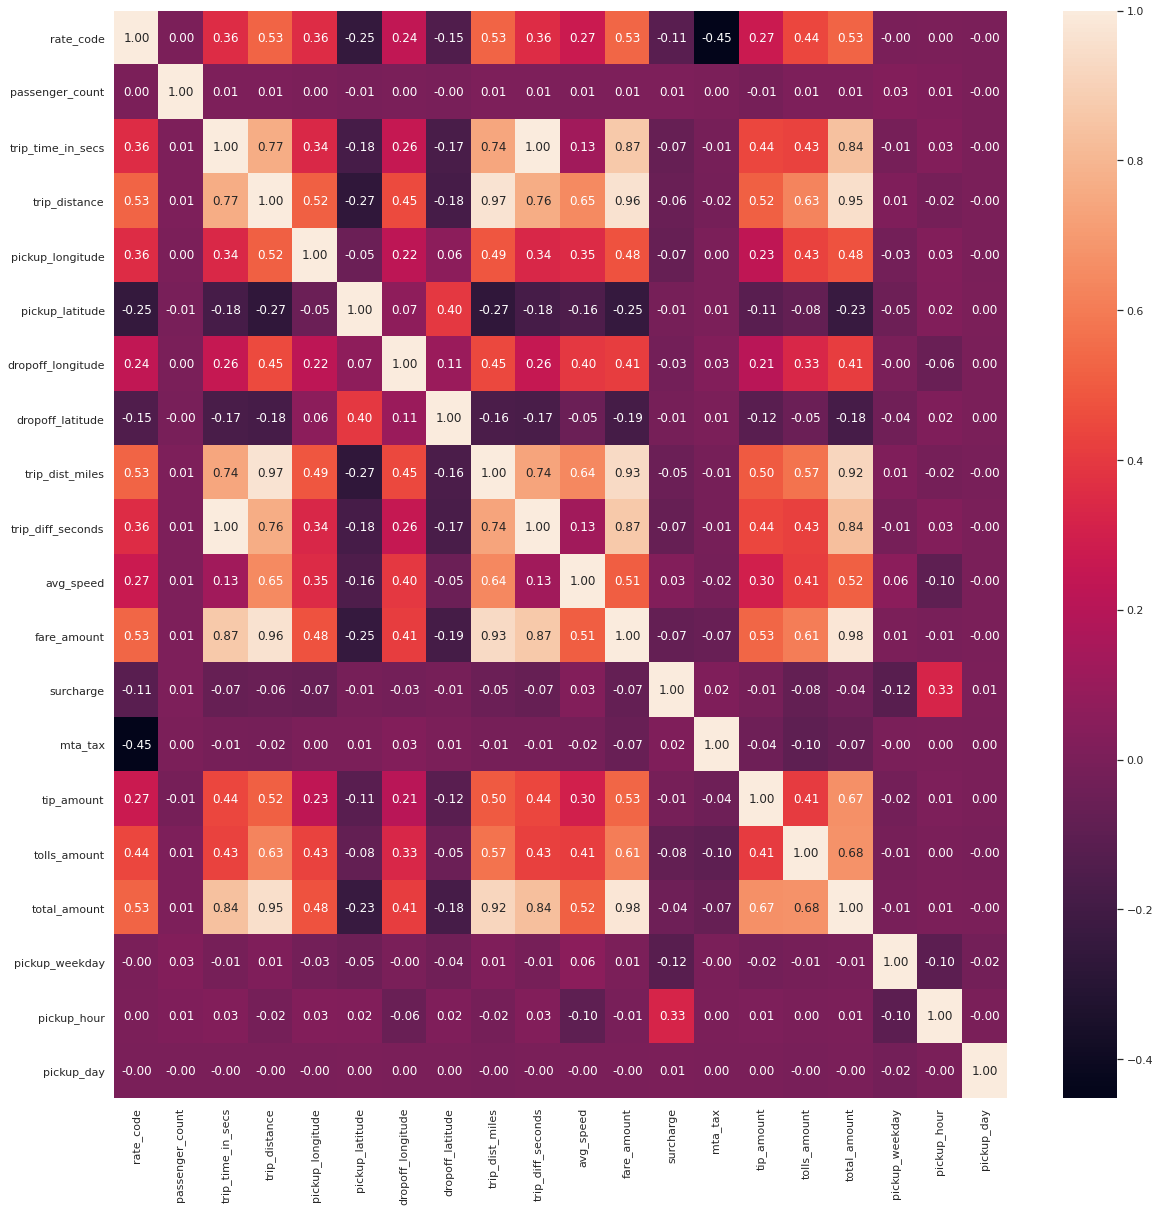

In [26]:
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(upd_taxi_trip_df.corr(), annot=True, fmt=".2f", ax=ax)
plt.show()

The most important features for predicting fare amount are:
- trip_distance (The distance travelled between pickup and dropoff locations)
- trip_diff_seconds (The time in seconds between pickup and dropoff datetime)
- total_amount ( The total amount incurred for the trip)

We may have to remove `total_amount` from the features as it might be too influential in predicting the `fare_amount`. `total_amount` is basically the summation of all the amounts incurred as part of the trip.

### Feature Engineering

Here we have to remove certain unnecessary columns, convert categorical columns into dummy columns (like one-hot encoding them), scale all the numerical columns within a certain range.

In [27]:
upd_taxi_trip_df.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_dist_miles', 'trip_diff_seconds', 'avg_speed', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'pickup_weekday', 'pickup_hour', 'pickup_day'],
      dtype='object')

In [28]:
for cols in upd_taxi_trip_df.columns:
    print('Number of unique values in %s is %s' %(cols, len(upd_taxi_trip_df[cols].unique())))

Number of unique values in medallion is 13299
Number of unique values in hack_license is 33191
Number of unique values in vendor_id is 2
Number of unique values in rate_code is 6
Number of unique values in pickup_datetime is 2279355
Number of unique values in dropoff_datetime is 2281415
Number of unique values in passenger_count is 6
Number of unique values in trip_time_in_secs is 6787
Number of unique values in trip_distance is 3391
Number of unique values in pickup_longitude is 31849
Number of unique values in pickup_latitude is 59571
Number of unique values in dropoff_longitude is 44230
Number of unique values in dropoff_latitude is 82196
Number of unique values in trip_dist_miles is 13758563
Number of unique values in trip_diff_seconds is 7092
Number of unique values in avg_speed is 303201
Number of unique values in payment_type is 5
Number of unique values in fare_amount is 232
Number of unique values in surcharge is 28
Number of unique values in mta_tax is 2
Number of unique valu

#### Dropping 'medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime', 'trip_time_in_secs', 'trip_dist_miles' columns

In [29]:
drop_columns = ['medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime', 'trip_time_in_secs', 'trip_dist_miles']
upd_taxi_trip_df = upd_taxi_trip_df.drop(drop_columns, axis = 1)

In [30]:
upd_taxi_trip_df.columns

Index(['vendor_id', 'rate_code', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_diff_seconds', 'avg_speed', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'pickup_weekday', 'pickup_hour', 'pickup_day'],
      dtype='object')

In [31]:
upd_taxi_trip_df.dtypes

vendor_id             object
rate_code              int64
passenger_count        int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_diff_seconds    float64
avg_speed            float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
pickup_weekday         int64
pickup_hour            int64
pickup_day             int64
dtype: object

#### Converting 'vendor_id', 'rate_code', 'passenger_count', 'payment_type', 'pickup_weekday', 'pickup_hour', 'pickup_day' into dummy variables

In [32]:
categorical_columns = ['vendor_id', 'rate_code', 'passenger_count', 'payment_type', 'pickup_weekday', 'pickup_hour', 
                       'pickup_day']

upd_taxi_trip_df = pd.get_dummies(upd_taxi_trip_df, columns=categorical_columns)

In [33]:
upd_taxi_trip_df.columns

Index(['trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_diff_seconds',
       'avg_speed', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'vendor_id_CMT', 'vendor_id_VTS',
       'rate_code_1', 'rate_code_2', 'rate_code_3', 'rate_code_4',
       'rate_code_5', 'rate_code_6', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'payment_type_CRD', 'payment_type_CSH',
       'payment_type_DIS', 'payment_type_NOC', 'payment_type_UNK',
       'pickup_weekday_0', 'pickup_weekday_1', 'pickup_weekday_2',
       'pickup_weekday_3', 'pickup_weekday_4', 'pickup_weekday_5',
       'pickup_weekday_6', 'pickup_hour_0', 'pickup_hour_1', 'pickup_hour_2',
       'pickup_hour_3', 'pickup_hour_4', 'pickup_hour_5', 'pickup_hour_6',
       'pickup_hour_7', 'pickup_hour_8', 'pickup_hour_9', 'pickup_hour_10',
       '

#### Scaling numerical columns using MinMax Scalar (except for the `Fare Amount`)

In [34]:
scaler = MinMaxScaler()

In [35]:
numerical_columns = ['trip_distance', 'trip_diff_seconds', 'avg_speed', 'surcharge', 'mta_tax', 
                     'tip_amount', 'tolls_amount', 'total_amount']

upd_taxi_trip_df[numerical_columns] = scaler.fit_transform(upd_taxi_trip_df[numerical_columns])

### Creating Training and Testing Dataset

In [36]:
X = upd_taxi_trip_df.drop(columns=['fare_amount'])
y = upd_taxi_trip_df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Running a basic Linear Regression model

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [38]:
# Display metrics
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
print("RMSE: %.3f" % np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

MSE: 26.470897656989283
RMSE: 5.145
R2: 0.6879887862240417


#### Running XGBoost Regressor model

In [39]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear', seed = 123)

# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
y_pred = xgb_r.predict(X_test)
  
# Display metrics
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

[02:26:56] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



MSE: 0.10637712300502764
RMSE: 0.32615505975690096
R2: 0.9987461379022018


#### Running the XGBoost Regressor model for different random states to see if a stable `mse` and `R2 Score` is achieved

#### Also calculating the feature importance scores for each feature

In [41]:
random_state_df = pd.DataFrame(
    {'run_id': list(range(0, 10)),
     'random_state': list(range(0, 10))
    })

taxi_feat_imp_df = pd.DataFrame(
    {'feat_name': list(X.columns)
    })

In [43]:
train_mse_list = []
test_mse_list = []
r2_score_list = []

for j in range(10):

    #split data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=j)

    # model first run with all the X variables
    xgb_r_model = xg.XGBRegressor(objective ='reg:linear', seed = 123)

    xgb_r_model.fit(X_train, y_train)

    train_preds = xgb_r_model.predict(X_train)
    test_preds = xgb_r_model.predict(X_test)

    train_mse_xgb = mean_squared_error(y_train, train_preds)
    test_mse_xgb = mean_squared_error(y_test, test_preds)
    r2_score_xgb = r2_score(y_test, test_preds)
    
    # write code to generate dataframe with run_id, random_state & frst_acc_rfc
    train_mse_list.append(train_mse_xgb)
    test_mse_list.append(test_mse_xgb)
    r2_score_list.append(r2_score_xgb)

    # generate the dictionary based on feature importance
    xgb_feat_imp_list = list(xgb_r_model.feature_importances_)

    xgb_feat_imp_dict = {}
    
    cols_list_upd = list(X_train.columns)
    
    for i in range(len(cols_list_upd)):
        xgb_feat_imp_dict[cols_list_upd[i]] = xgb_feat_imp_list[i]

    col_str = 'col_rs_'+str(j)
    
    xgb_taxi_df = pd.DataFrame(xgb_feat_imp_dict.items(), columns=['feat_name', col_str])
    
    taxi_feat_imp_df = pd.merge(taxi_feat_imp_df, xgb_taxi_df, on='feat_name')
    
random_state_df['train_mse'] = train_mse_list
random_state_df['test_mse'] = test_mse_list
random_state_df['test_r2_score'] = r2_score_list

[03:12:07] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[03:30:33] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[03:49:01] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[04:07:24] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[04:25:47] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[04:44:11] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[05:02:31] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[05:20:49] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[05:39:10] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[05:57:31] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [44]:
random_state_df

run_id  random_state  train_mse  test_mse  test_r2_score
0       0             0   0.104883  0.107650       0.998730
1       1             1   0.104917  0.106701       0.998741
2       2             2   0.104095  0.104831       0.998764
3       3             3   0.105051  0.107714       0.998730
4       4             4   0.103061  0.107655       0.998729
5       5             5   0.104212  0.105511       0.998756
6       6             6   0.103841  0.106819       0.998739
7       7             7   0.102818  0.103527       0.998779
8       8             8   0.104333  0.107349       0.998735
9       9             9   0.105821  0.107148       0.998736

In [45]:
taxi_feat_imp_df

feat_name  col_rs_0  col_rs_1  col_rs_2  col_rs_3  col_rs_4  \
0       trip_distance  0.030797  0.042267  0.027833  0.030017  0.028331   
1    pickup_longitude  0.000289  0.000440  0.000278  0.000237  0.000187   
2     pickup_latitude  0.000192  0.000283  0.000243  0.000151  0.000524   
3   dropoff_longitude  0.000180  0.000153  0.000182  0.000219  0.000202   
4    dropoff_latitude  0.000144  0.000211  0.000190  0.000168  0.000215   
..                ...       ...       ...       ...       ...       ...   
88      pickup_day_27  0.000158  0.000022  0.000217  0.000062  0.000167   
89      pickup_day_28  0.000000  0.000038  0.000016  0.000046  0.000055   
90      pickup_day_29  0.000117  0.000121  0.000016  0.000054  0.000000   
91      pickup_day_30  0.000044  0.000157  0.000084  0.000030  0.000076   
92      pickup_day_31  0.000112  0.000086  0.000076  0.000056  0.000091   

    col_rs_5  col_rs_6  col_rs_7  col_rs_8  col_rs_9  
0   0.036242  0.030996  0.038245  0.083166  0.032294  
1   0.000354  0.000408  0.000483  0.000318  0.000374  
2   0.000323  0.000210  0.000173  0.000419  0.000236  
3   0.000203  0.000157  0.000160  0.000146  0.000200  
4   0.000240  0.000212  0.000166  0.000157  0.000175  
..       ...       ...       ...       ...       ...  
88  0.000000  0.000139  0.000152  0.000193  0.000014  
89  0.000035  0.000041  0.000000  0.000000  0.000007  
90  0.000104  0.000169  0.000141  0.000334  0.000084  
91  0.000000  0.000065  0.000000  0.000088  0.000000  
92  0.000038  0.000038  0.000061  0.000000  0.000040  

[93 rows x 11 columns]

#### Calculating the mean and standard deviation of the feature importance scores for all the features for different random states for predicting the fare amount

In [46]:
rs_feat_cols = list(taxi_feat_imp_df.columns)

In [47]:
rs_feat_cols.remove('feat_name')

In [48]:
rs_feat_cols

['col_rs_0',
 'col_rs_1',
 'col_rs_2',
 'col_rs_3',
 'col_rs_4',
 'col_rs_5',
 'col_rs_6',
 'col_rs_7',
 'col_rs_8',
 'col_rs_9']

In [49]:
taxi_feat_imp_df['mean'] = taxi_feat_imp_df[rs_feat_cols].mean(axis=1)
taxi_feat_imp_df['stdev'] = taxi_feat_imp_df[rs_feat_cols].std(axis=1)

#### Sorting the dataframe based on mean feature importance score

In [50]:
sorted_taxi_feat_imp_df = taxi_feat_imp_df.sort_values(by=['mean'], ascending=False)

In [51]:
sorted_taxi_feat_imp_df.head(50)

feat_name      col_rs_0  col_rs_1  col_rs_2  col_rs_3  col_rs_4  \
11       total_amount  7.690970e-01  0.775971  0.780445  0.750491  0.783898   
14        rate_code_1  1.428597e-01  0.126262  0.140974  0.168049  0.132430   
0       trip_distance  3.079672e-02  0.042267  0.027833  0.030017  0.028331   
5   trip_diff_seconds  1.715099e-02  0.014011  0.016970  0.016442  0.018040   
9          tip_amount  1.506538e-02  0.013737  0.013367  0.014135  0.013879   
10       tolls_amount  6.844961e-03  0.005602  0.006112  0.006459  0.006818   
15        rate_code_2  5.235330e-03  0.011607  0.004075  0.003750  0.004254   
7           surcharge  3.549772e-03  0.003526  0.002827  0.002963  0.003189   
18        rate_code_5  2.169902e-03  0.000183  0.001643  0.001791  0.001943   
6           avg_speed  6.832342e-04  0.000591  0.000704  0.000806  0.000723   
51     pickup_hour_13  5.206935e-04  0.000270  0.000337  0.000370  0.000376   
1    pickup_longitude  2.885909e-04  0.000440  0.000278  0.000237  0.000187   
50     pickup_hour_12  4.977721e-04  0.000386  0.000333  0.000225  0.000320   
2     pickup_latitude  1.920993e-04  0.000283  0.000243  0.000151  0.000524   
19        rate_code_6  2.606477e-04  0.000001  0.000367  0.000353  0.000438   
49     pickup_hour_11  3.180494e-04  0.000127  0.000163  0.000199  0.000215   
46      pickup_hour_8  1.691388e-04  0.000188  0.000196  0.000276  0.000132   
4    dropoff_latitude  1.439577e-04  0.000211  0.000190  0.000168  0.000215   
8             mta_tax  1.688727e-04  0.000139  0.000126  0.000151  0.000221   
3   dropoff_longitude  1.799128e-04  0.000153  0.000182  0.000219  0.000202   
53     pickup_hour_15  1.747844e-04  0.000188  0.000212  0.000169  0.000197   
45      pickup_hour_7  2.956264e-04  0.000142  0.000087  0.000174  0.000120   
38      pickup_hour_0  6.417407e-05  0.000237  0.000086  0.000080  0.000099   
57     pickup_hour_19  1.721625e-04  0.000115  0.000118  0.000144  0.000139   
16        rate_code_3  1.706756e-04  0.000089  0.000132  0.000116  0.000124   
90      pickup_day_29  1.168368e-04  0.000121  0.000016  0.000054  0.000000   
88      pickup_day_27  1.579118e-04  0.000022  0.000217  0.000062  0.000167   
64       pickup_day_3  1.755097e-04  0.000259  0.000000  0.000197  0.000127   
68       pickup_day_7  8.761518e-05  0.000123  0.000125  0.000036  0.000171   
17        rate_code_4  1.108520e-04  0.000091  0.000116  0.000073  0.000081   
12      vendor_id_CMT  1.016029e-04  0.000105  0.000109  0.000097  0.000115   
79      pickup_day_18  1.354429e-04  0.000071  0.000073  0.000099  0.000100   
58     pickup_hour_20  1.234124e-04  0.000065  0.000096  0.000065  0.000113   
86      pickup_day_25  6.994895e-05  0.000034  0.000033  0.000226  0.000012   
70       pickup_day_9  3.668228e-08  0.000097  0.000038  0.000000  0.000019   
43      pickup_hour_5  2.220147e-04  0.000290  0.000107  0.000000  0.000030   
27   payment_type_CSH  8.896697e-05  0.000178  0.000058  0.000078  0.000054   
37   pickup_weekday_6  1.463826e-05  0.000257  0.000074  0.000099  0.000089   
35   pickup_weekday_4  9.491396e-05  0.000078  0.000059  0.000067  0.000100   
47      pickup_hour_9  4.597447e-05  0.000227  0.000047  0.000000  0.000121   
48     pickup_hour_10  8.336491e-05  0.000116  0.000073  0.000062  0.000065   
54     pickup_hour_16  4.281610e-05  0.000074  0.000035  0.000042  0.000097   
73      pickup_day_12  2.632855e-05  0.000135  0.000051  0.000000  0.000071   
59     pickup_hour_21  5.647586e-05  0.000053  0.000081  0.000052  0.000064   
92      pickup_day_31  1.123432e-04  0.000086  0.000076  0.000056  0.000091   
91      pickup_day_30  4.426961e-05  0.000157  0.000084  0.000030  0.000076   
56     pickup_hour_18  5.993057e-05  0.000063  0.000047  0.000044  0.000046   
32   pickup_weekday_1  4.630883e-05  0.000019  0.000005  0.000056  0.000274   
52     pickup_hour_14  9.057626e-05  0.000000  0.000003  0.000083  0.000045   
60     pickup_hour_22  2.781676e-05  0.000064  0.000028  0.000

`total_amount` proves to be an important feature with a very high feature importance score, similar to what we saw above in the correlation matrix. It is better to try to predict the `fare_amount` without `total_amount`

#### Running the model one last time without `total_amount`

In [52]:
X = upd_taxi_trip_df.drop(columns=['fare_amount', 'total_amount'])
y = upd_taxi_trip_df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear', seed = 123)

# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
y_pred = xgb_r.predict(X_test)
  
# Display metrics
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

[08:21:33] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


/home/ml/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



MSE: 0.5540301086044122
RMSE: 0.7443319881641606
R2: 0.9934696734166684
